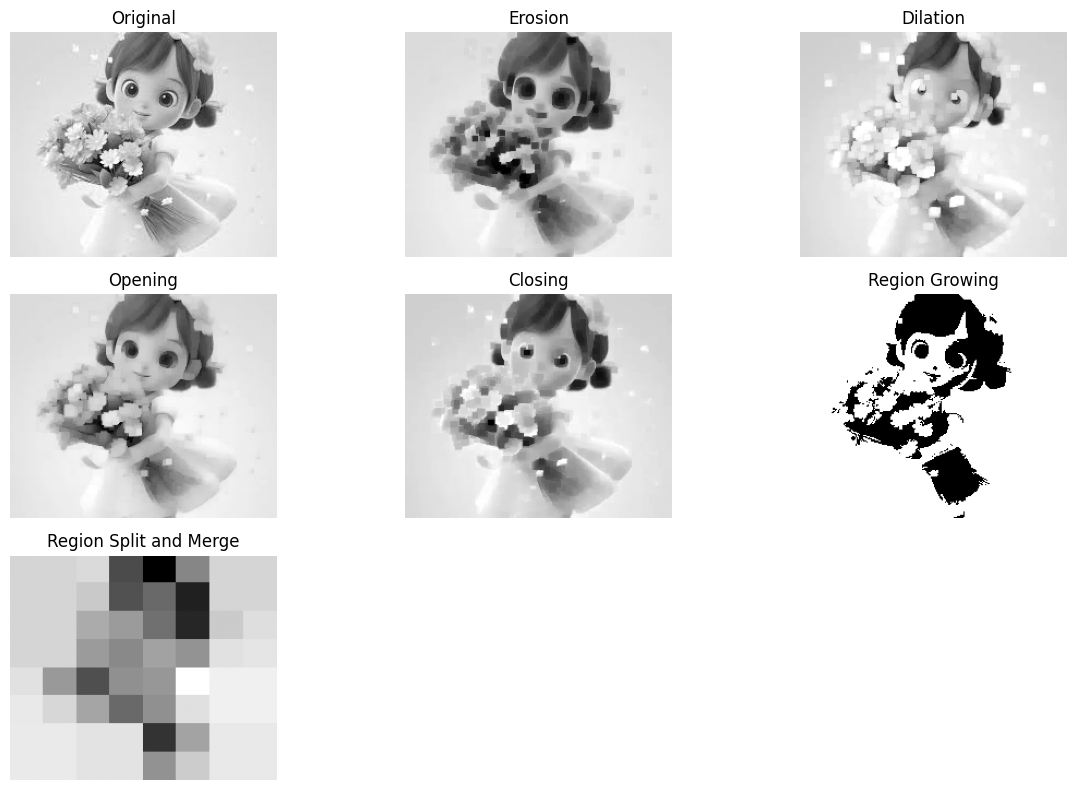

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('img_1.jpg', 0)  # Read as grayscale

kernel = np.ones((5,5), np.uint8)
erosion = cv2.erode(img, kernel, iterations=1)
dilation = cv2.dilate(img, kernel, iterations=1)
opening = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

# Simple region growing (threshold-based, single seed)
def region_grow(img, seed, thresh=60):
    visited = np.zeros_like(img, dtype=bool)
    seg = np.zeros_like(img)
    h, w = img.shape
    stack = [seed]
    seed_val = img[seed]
    while stack:
        x, y = stack.pop()
        if visited[x, y]:
            continue
        visited[x, y] = True
        if abs(int(img[x, y]) - int(seed_val)) < thresh:
            seg[x, y] = 255
            for dx in [-1,0,1]:
                for dy in [-1,0,1]:
                    nx, ny = x+dx, y+dy
                    if 0<=nx<h and 0<=ny<w and not visited[nx, ny]:
                        stack.append((nx, ny))
    return seg

seed_point = (200, 200)
seg_img = region_grow(img, seed_point)

# Show results in a single window
titles = ['Original', 'Erosion', 'Dilation', 'Opening', 'Closing', 'Region Growing','Region Split and Merge']
images = [img, erosion, dilation, opening, closing, seg_img,split_merge_img]

plt.figure(figsize=(12, 8))
for i in range(len(titles)):
    plt.subplot(3, 3, i+1)  # 3 rows, 3 columns
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [8]:
img.shape

(206, 245)

In [36]:
def split_and_merge(img, min_size=32, threshold=25):
    """
    Region splitting and merging using quad-tree decomposition (cv2 functions)
    img: Grayscale image (2D numpy array)
    min_size: Minimum region size
    threshold: Intensity variance threshold for splitting
    """
    def split(img, x, y, w, h):
        roi = img[y:y+h, x:x+w]
        if w <= min_size or h <= min_size or np.std(roi) < threshold:
            return [(x, y, w, h)]
        else:
            regions = []
            hw, hh = w//2, h//2
            regions += split(img, x, y, hw, hh)
            regions += split(img, x+hw, y, w-hw, hh)
            regions += split(img, x, y+hh, hw, h-hh)
            regions += split(img, x+hw, y+hh, w-hw, h-hh)
            return regions

    h, w = img.shape
    regions = split(img, 0, 0, w, h)
    seg_img = np.zeros_like(img)
    for x, y, rw, rh in regions:
        roi = img[y:y+rh, x:x+rw]
        mean = int(np.mean(roi))
        seg_img[y:y+rh, x:x+rw] = mean
    return seg_img

split_merge_img = split_and_merge(img, min_size=32)